# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory_partial"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Aug25-1537'

In [4]:
concord_methods = ['concord_hcl', 'concord_knn']
other_methods = [
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi",  'contrastive'
]
run_methods =  other_methods + concord_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [5]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'

## Simulation

In [ ]:
from concord.simulation import (
    Simulation,
    SimConfig,
    TrajectoryConfig,   # ← because state_type == 'trajectory'
    BatchConfig,
)

# ── 1. global simulation settings ──────────────────────────────────
sim_cfg = SimConfig(
    n_cells = 1000,
    n_genes = 1000,
    seed    =    42,
    non_neg =  True,
    to_int  =  True,
)

# ── 2. trajectory (state) settings ─────────────────────────────────
traj_cfg = TrajectoryConfig(
    # generic “state” parameters
    distribution   = "normal",   # ← state_distribution
    level          = 10,         # ← state_level
    min_level      = 0,          # ← state_min_level
    dispersion     = 6.0,        # ← state_dispersion

    # trajectory-specific knobs (copied 1-to-1)
    program_num            = 5,              # trajectory_program_num
    program_structure      = "linear_bidirectional",
    program_on_time_fraction = 0.2,
    cell_block_size_ratio  = 0.6,
    loop_to                = None,
)

# ── 3. batch settings ──────────────────────────────────────────────
batch_cfg = BatchConfig(
    n_batches    = 2,
    effect_type  = "batch_specific_features",    # batch_type
    distribution = "normal",                     # batch_distribution
    level        = [10, 10],                     # batch_level
    dispersion   = [6.0, 6.0],                   # batch_dispersion
    feature_frac = 0.1,                          # matches the old default
    # cell_proportion defaults to [0.5, 0.5] because n_batches = 2
)

# ── 4. run the simulation ──────────────────────────────────────────
sim   = Simulation(sim_cfg, traj_cfg, batch_cfg)
adata_state = sim.simulate_state()

print(adata_state.shape)

In [ ]:
# Define cell indices for each batch, with partial overlap
batch1_time = adata_state.obs['time'] < 600
batch2_time = adata_state.obs['time'] > 400
batch1_idx = np.where(batch1_time)[0]
batch2_idx = np.where(batch2_time)[0]

batch_indices = {0: batch1_idx, 1: batch2_idx}

In [ ]:
batch_list, state_list = [], []
for i in range(len(batch_indices)):
    batch_adata_pre = adata_state[batch_indices[i]].copy()
    batch_adata = sim.simulate_batch(
        batch_adata_pre,
        batch_idx=i)
    batch_list.append(batch_adata)
    state_list.append(batch_adata_pre)

adata = sim._finalize_anndata(batch_list, join='outer')
adata_state = sim._finalize_anndata(state_list, join='outer')


In [ ]:
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 3
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"data_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

## Integration pipeline

In [ ]:
run_methods = concord_methods + other_methods
#run_methods = concord_methods
latent_dim = 30


In [ ]:
# Add ground truth
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='no_noise_PCA', n_pc=latent_dim, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='wt_noise_PCA', n_pc=latent_dim, random_state=seed)
# Put the PCA result in the adata object, so only one object is needed
adata.obsm['no_noise'] = adata.obsm['no_noise_PCA'] = adata_state.obsm['no_noise_PCA']
adata.obsm['wt_noise'] = adata.obsm['wt_noise_PCA'] = adata_state.obsm['wt_noise_PCA']
ccd.ul.run_umap(adata, source_key='no_noise', result_key='no_noise_UMAP', n_components=2, random_state=seed)
ccd.ul.run_umap(adata, source_key='wt_noise', result_key='wt_noise_UMAP', n_components=2, random_state=seed)

In [ ]:
concord_kwargs = {
    'batch_size': 32,
    'n_epochs': 20,
    'preload_dense': True,
    'verbose': False,
}
profile_logs = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=run_methods,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=seed,                              # Random seed for reproducibility
    compute_umap=False,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
    concord_kwargs=concord_kwargs,          # Additional kwargs for CONCORD
)


In [ ]:
for basis in run_methods:
    if 'PCA' not in basis:
        n_pc = min(adata.obsm[basis].shape[1], adata.shape[0]) - 1
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)
    print("Running UMAP for", basis)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

concord.plotting.pl_embedding - INFO - Plotting no_noise with time in KNN
concord.plotting.pl_embedding - INFO - Plotting wt_noise with time in KNN
concord.plotting.pl_embedding - INFO - Plotting scanorama with time in KNN
concord.plotting.pl_embedding - INFO - Plotting liger with time in KNN
concord.plotting.pl_embedding - INFO - Plotting harmony with time in KNN
concord.plotting.pl_embedding - INFO - Plotting scvi with time in KNN
concord.plotting.pl_embedding - INFO - Plotting contrastive with time in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with time in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_knn with time in KNN


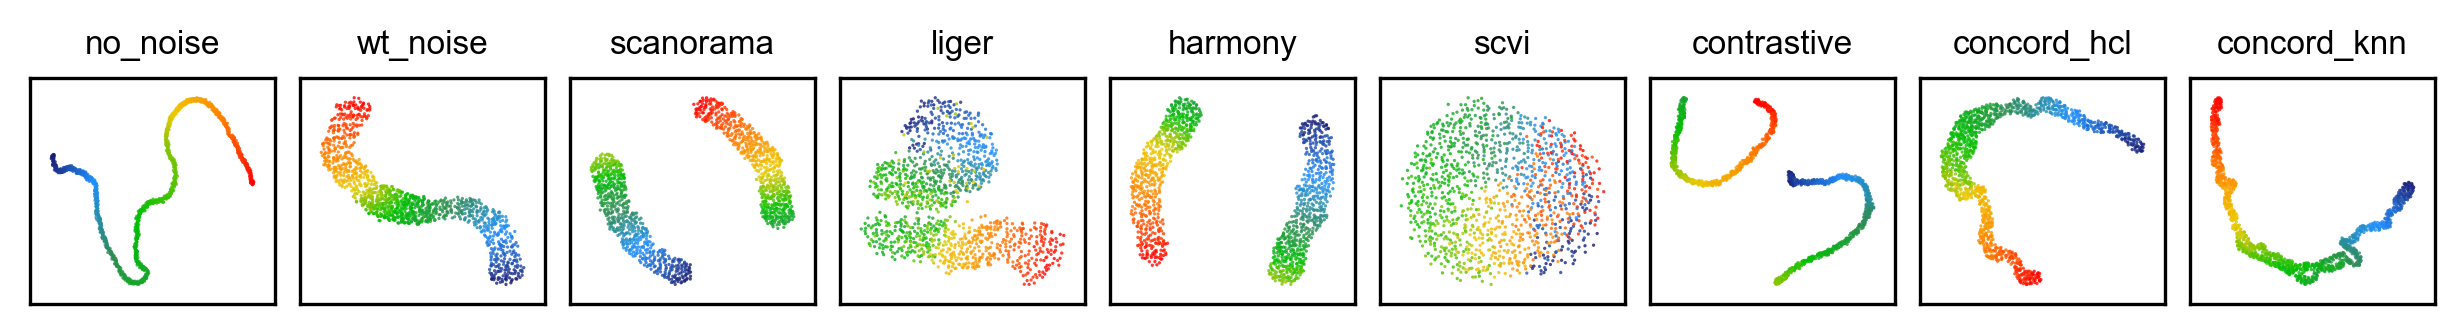

concord.plotting.pl_embedding - INFO - Plotting no_noise with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting wt_noise with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting scanorama with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting liger with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting harmony with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting scvi with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting contrastive with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_knn with batch in KNN


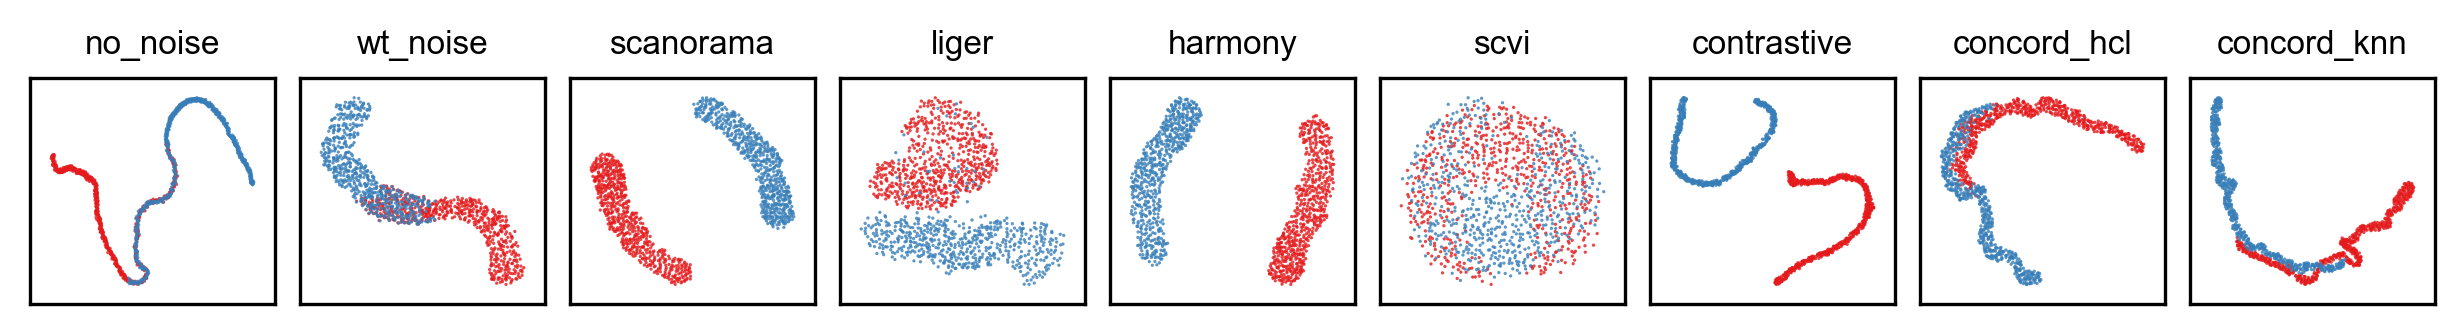

concord.plotting.pl_embedding - INFO - Plotting no_noise with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting wt_noise with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with time in UMAP


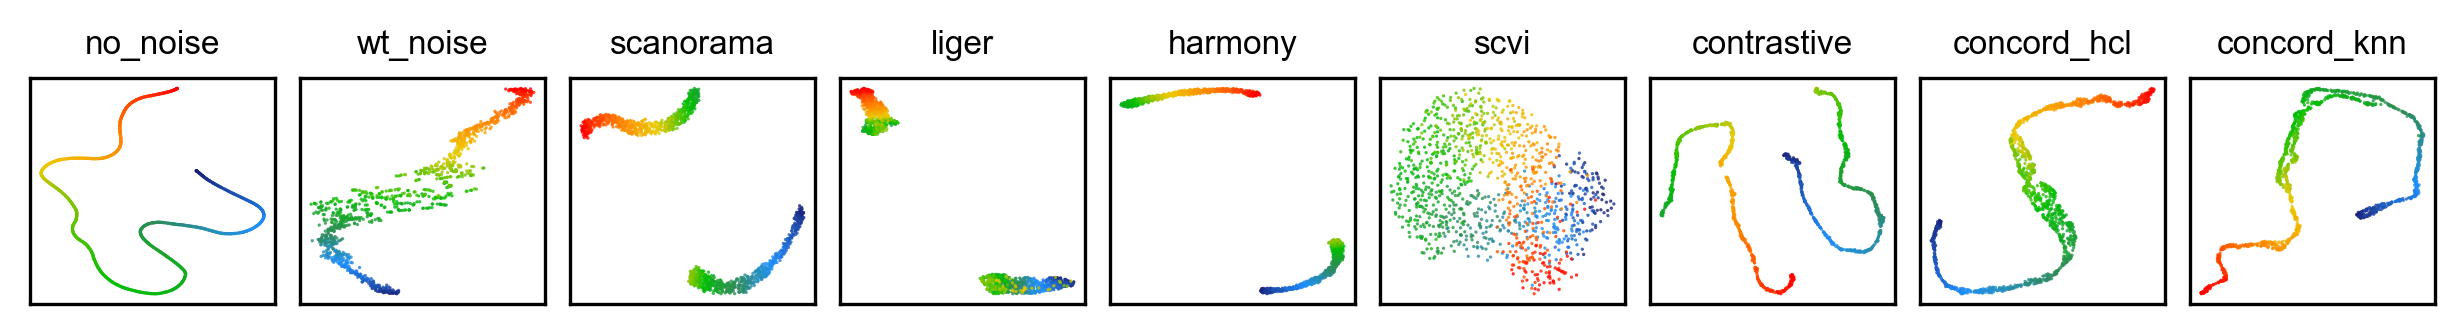

concord.plotting.pl_embedding - INFO - Plotting no_noise with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting wt_noise with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with batch in UMAP


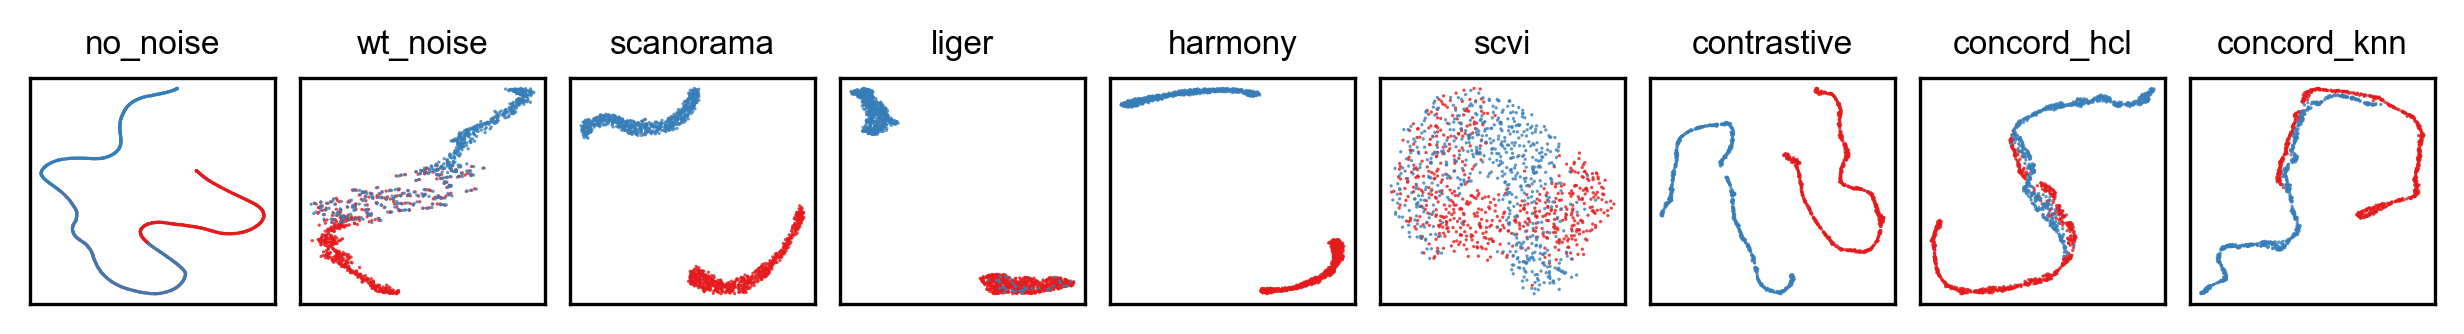

In [64]:
# plot everything
import matplotlib.pyplot as plt

show_keys = [key for key in combined_keys if key != 'unintegrated']

# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch']
basis_types = ['KNN', 'UMAP']
#basis_types = ['PCA']

font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'BlueGreenRed', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed+10,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [ ]:
# Find the indices of common genes between `adata` and `adata_state`
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_knn', path=batch_indices, sigma=2)
adata.obsm['concord_knn_sorted'] = adata.obsm['concord_knn'][:, feature_order]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_hcl', path=batch_indices, sigma=2)
adata.obsm['concord_hcl_sorted'] = adata.obsm['concord_hcl'][:, feature_order]


In [ ]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
_, _, state_pal = ccd.pl.get_color_mapping(adata, state_key, pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=seed)
pal = {state_key: state_pal, batch_key: batch_pal}
dpi = 600
with plt.rc_context(rc=custom_rc):
    fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
    ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='wt_noise', vmax=15, obs_keys=[state_key], ax = axes[1], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='X', vmax=15, obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_hcl_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord HCL latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_knn_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord KNN latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    plt.tight_layout(w_pad=0.0, h_pad=0.1)
    plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [65]:
# Save result
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")
print(f"Saved adata_state to {data_dir / f'adata_state_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_trajectory_partial/adata_Aug11-1952.h5ad
Saved adata_state to ../data/simulation_trajectory_partial/adata_state_Aug11-1952.h5ad


## Evaluation

In [6]:
# adata = sc.read(data_dir / f"adata_Jul24-2239.h5ad")
# adata_state = sc.read(data_dir / f"adata_state_Jul24-2239.h5ad")
adata = sc.read(data_dir / f"adata_Aug11-1952.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Aug11-1952.h5ad")

In [7]:
# Generate Leiden clusters for the clean state data as pseudo labels
leiden_key = 'leiden_no_noise'
sc.pp.neighbors(adata_state, use_rep='no_noise_PCA', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata_state, resolution=1.0, key_added=leiden_key, random_state=seed)
adata.obs[leiden_key] = adata_state.obs[leiden_key]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


concord - INFO - Running SCIB benchmark


Embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings:  10%|█         | 1/10 [00:04<00:36,  4.10s/it]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings:  20%|██        | 2/10 [00:04<00:15,  1.90s/it]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings:  30%|███       | 3/10 [00:04<00:08,  1.23s/it]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings:  40%|████      | 4/10 [00:05<00:05,  1.19it/s]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings:  50%|█████     | 5/10 [00:05<00:03,  1.50it/s]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings:  60%|██████    | 6/10 [00:05<00:02,  1.91it/s]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings:  70%|███████   | 7/10 [00:06<00:01,  1.91it/s]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings:  80%|████████  | 8/10 [00:06<00:00,  2.34it/s]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings:  90%|█████████ | 9/10 [00:06<00:00,  2.49it/s]

INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.                                                      
INFO     18 consists of a single batch or is too small. Skip.                                                      
INFO     2 consists of a single batch or is too small. Skip.                                                       
INFO     20 consists of a single batch or is too small. Skip.                                                      
INFO     3 consists of a single batch or is too small. Skip.            

Embeddings: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


concord - INFO - Running Probe benchmark
Detected task: classification
[KNN] detected task: classification
concord - INFO - Computing cell distance correlation
concord - INFO - Computing trustworthiness
concord - INFO - Computing state dispersion correlation
concord - INFO - Saved full geometry benchmark results to ../save/dev_simulation_trajectory_partial-Aug25/benchmarks_out/geometry_results_Aug25-1537.pkl


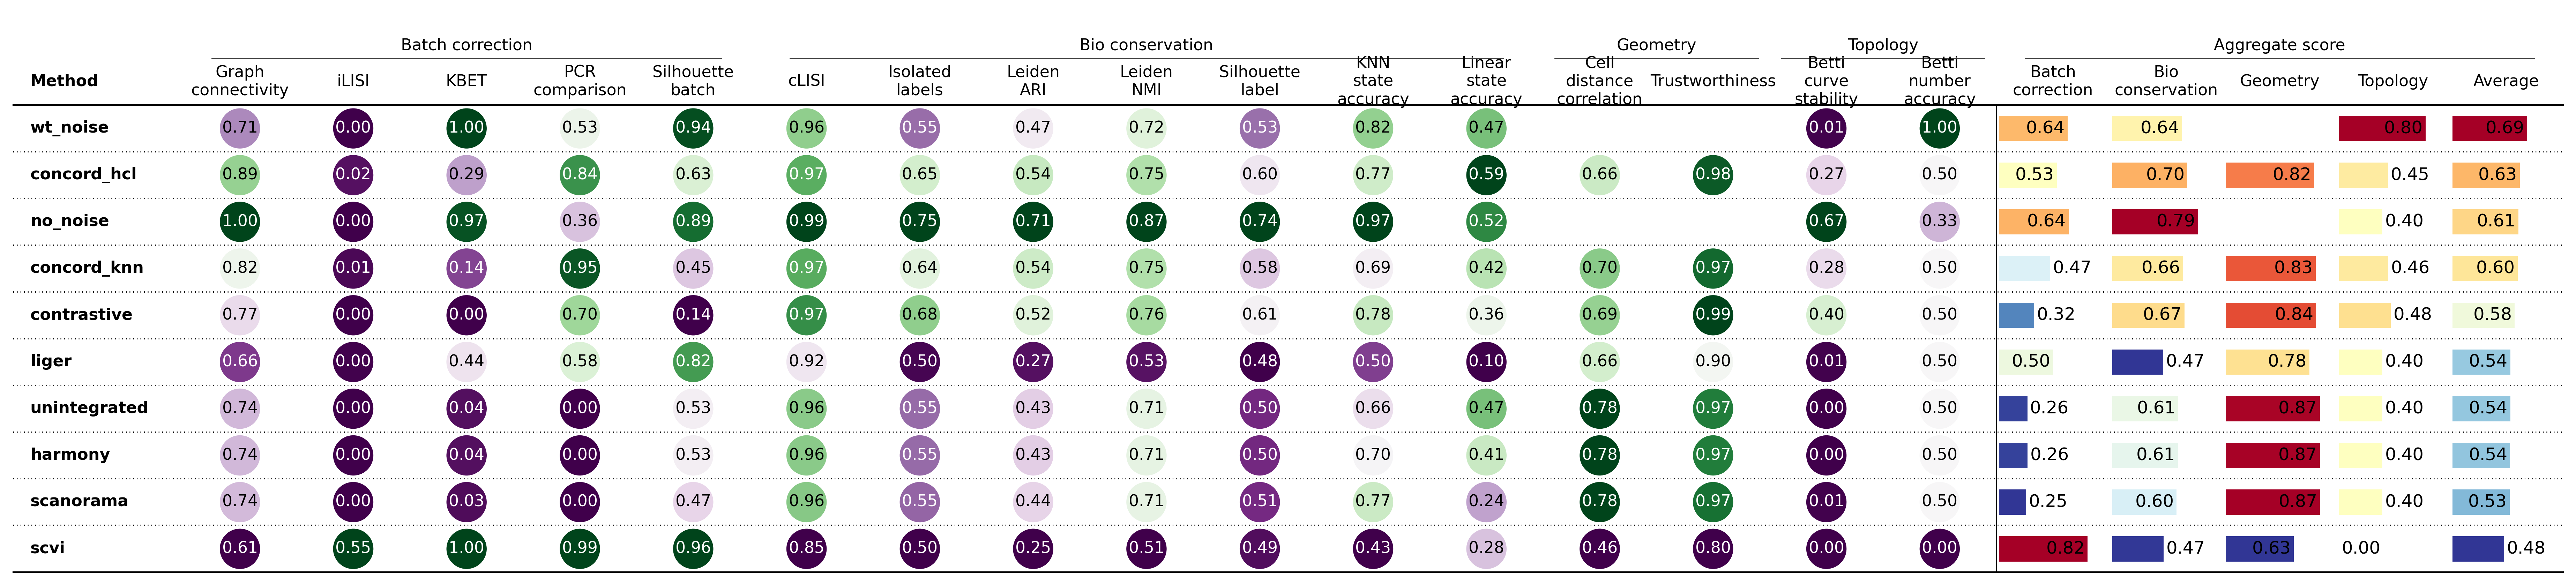

concord - INFO - Saved benchmark results to ../save/dev_simulation_trajectory_partial-Aug25/benchmarks_out/benchmark_results_Aug25-1537.pkl


Batch correction                                     \
            Graph connectivity     iLISI      KBET PCR comparison   
wt_noise              0.705654       0.0       1.0       0.529473   
concord_hcl           0.890914  0.023103  0.290773       0.839616   
no_noise                   1.0       0.0  0.970085       0.355978   
concord_knn           0.816592  0.010942  0.140409        0.94897   
contrastive           0.772769       0.0       0.0       0.699794   

                             Bio conservation                             \
            Silhouette batch            cLISI Isolated labels Leiden ARI   
wt_noise            0.942833         0.955274        0.550396   0.465018   
concord_hcl         0.629695         0.965427         0.65342   0.543971   
no_noise            0.892308         0.994904        0.750199   0.710257   
concord_knn         0.447401         0.966436         0.64281   0.537943   
contrastive         0.144794         0.973993        0.682598   0.516049   

                                         ...                        \
            Leiden NMI Silhouette label  ... Linear state accuracy   
wt_noise      0.716809         0.532073  ...              0.468619   
concord_hcl   0.753021         0.598119  ...              0.585774   
no_noise      0.866124         0.743808  ...              0.523013   
concord_knn   0.753004         0.577063  ...              0.422594   
contrastive   0.760237         0.606816  ...              0.359833   

                             Geometry                              Topology  \
            Cell distance correlation Trustworthiness Betti curve stability   
wt_noise                          NaN             NaN              0.005528   
concord_hcl                  0.660213        0.977782              0.270542   
no_noise                          NaN             NaN              0.666670   
concord_knn                  0.695379        0.972540              0.281415   
contrastive                  0.690191        0.986073              0.403239   

                                   Aggregate score                             \
            Betti number accuracy Batch correction Bio conservation  Geometry   
wt_noise                 1.000000         0.635592         0.644741       NaN   
concord_hcl              0.500000         0.534820         0.695200  0.818998   
no_noise                 0.333333         0.643674         0.794758       NaN   
concord_knn              0.500000         0.472863         0.655336  0.833960   
contrastive              0.500000         0.323471         0.667789  0.838132   

                                 
             Topology   Average  
wt_noise     0.801106  0.693813  
concord_hcl  0.454108  0.625782  
no_noise     0.400001  0.612811  
concord_knn  0.456283  0.604610  
contrastive  0.480648  0.577510  

[5 rows x 21 columns]

In [8]:
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=combined_keys,
    state_key=leiden_key,
    batch_key=batch_key,
    groundtruth_key="no_noise",  # use the Leiden clusters as ground truth
    save_dir=save_dir / "benchmarks_out",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("scib", "probe", "geometry", "topology"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
    expected_betti_numbers=[0,0,0],  # expected Betti numbers for the geometry and topology blocks
    max_points=1000,
    verbose=True,
    seed=seed,  # for reproducibility
)
combined = out["combined"]
combined.head()

In [9]:
import pickle
out = pickle.load(open(Path("../save/dev_simulation_trajectory_partial-Aug25/benchmarks_out") / f"benchmark_results_Aug25-1537.pkl", "rb"))
combined = out["combined"]

with open('../save/dev_simulation_trajectory_partial-Aug25/benchmarks_out/topology_diagrams_Aug25-1537.pkl', 'rb') as f:
    diagrams = pickle.load(f)

geometry_full = pickle.load(open(Path("../save/dev_simulation_trajectory_partial-Aug25/benchmarks_out/geometry_results_Aug25-1537.pkl"), "rb"))


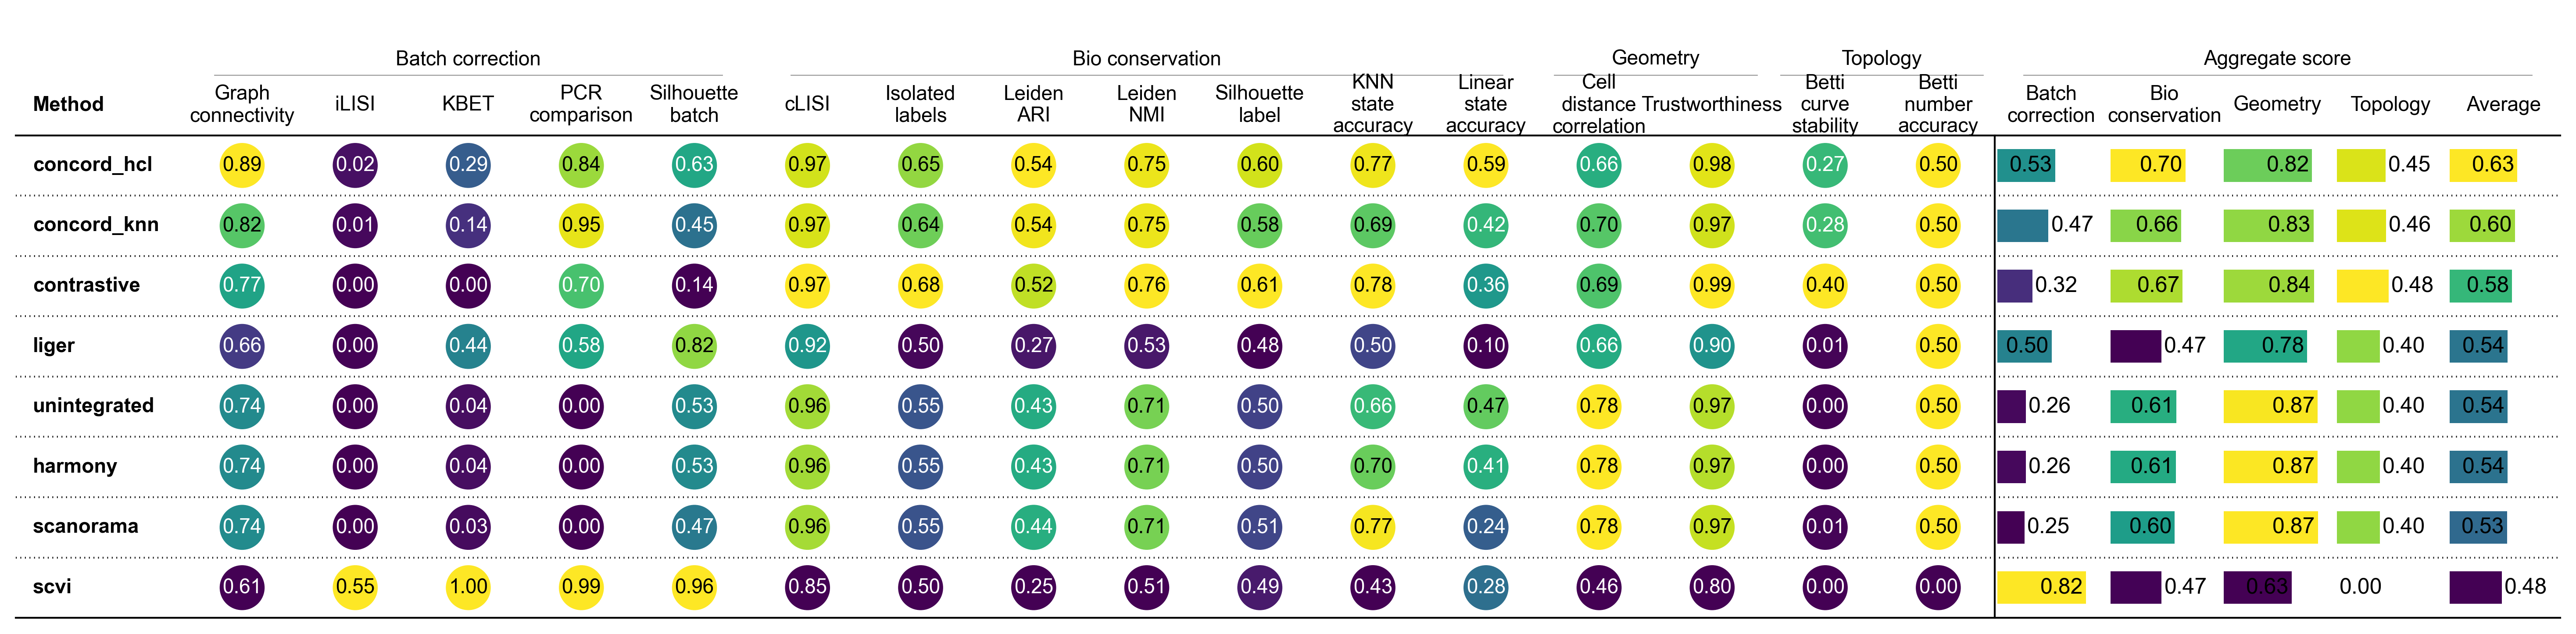

In [10]:
import pickle
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
with plt.rc_context(rc=custom_rc):
    combined_df = ccd.bm.combine_benchmark_results(
        out,
        block_include=("geometry", "topology", "scib", "probe"),
        plot=False,
        save_path=save_dir / f"combined_res_{file_suffix}.pdf",
        table_plot_kw=table_plot_kw,
    )
    ccd.bm.plot_benchmark_table(
            combined_df.dropna(axis=0, how='any'),
            save_path=save_dir / f"benchmark_table_{file_suffix}.svg",
            agg_name="Aggregate score",
            figsize=(25, 6),
            **table_plot_kw
            )

In [ ]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

In [ ]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

In [ ]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, min_gap=0.0005, legend=False, save_path=save_dir / f"trustworthiness_{file_suffix}.pdf", figsize=(4,3))